# RNN - LSTM

# RNN  

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms



import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from matplotlib.pyplot import imshow
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader

In [ ]:
x = torch.tensor([4,5])
y = torch.tensor([1,9])

torch.cat((x,y))

z = torch.sigmoid(x)


g = torch.dot(x,y)
g

tensor(49)

In [ ]:
D = 28*28
n = 256
C = 1

classes = 10

model_regular = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, classes),
)

In [ ]:
h_2 = nn.Linear(n, n)

model_shared = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(), h_2,
    nn.Tanh(), h_2,
    nn.Tanh(),
    nn.Linear(n, classes),
)

# Lets build an RNN network

In [ ]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file.
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too.


Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [ ]:
namge_language_data.keys()

dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])

In [ ]:
# Show the first 10 Arabic names in the dataset
print("First 10 Arabic names in the dataset:")
for i, name in enumerate(namge_language_data["Arabic"][:10], 1):
    print(f"{i}. {name}")

First 10 Arabic names in the dataset:
1. khoury
2. nahas
3. daher
4. gerges
5. nazari
6. maalouf
7. gerges
8. naifeh
9. guirguis
10. baba


In [ ]:
class LanguageNameDataset(Dataset):
    '''
    self.label_names becomes ['English', 'Spanish', 'Japanese']
    self.data becomes ['Smith', 'Johnson', 'Williams', 'Garcia', 'Rodriguez', 'Lopez', 'Tanaka', 'Suzuki', 'Sato']
    self.labels becomes [0, 0, 0, 1, 1, 1, 2, 2, 2] (0 for English, 1 for Spanish, 2 for Japanese)

    Now, let's see what happens when we access a specific item, for example dataset[4]:

    The __getitem__ method is called with idx=4
    It retrieves name = self.data[4] which is 'Rodriguez'
    It retrieves label = self.labels[4] which is 1 (Spanish)
    It calls self.string2InputVec('Rodriguez') which does the following:

    Creates a tensor of zeros with length 9 (number of characters in "Rodriguez")
    For each character, it replaces the zeros with the corresponding integer from the vocabulary:

    'R' → 44
    'o' → 15
    'd' → 4
    'r' → 18
    'i' → 9
    'g' → 7
    'u' → 21
    'e' → 5
    'z' → 26


    This creates the tensor: tensor([44, 15, 4, 18, 9, 7, 21, 5, 26])


    It converts the label 1 to a tensor: tensor([1])
    It returns the tuple: (tensor([44, 15, 4, 18, 9, 7, 21, 5, 26]), tensor([1]))
    '''

    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        # Amr
        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        # [0,0,0]
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        # Convert the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label


In [ ]:
dataset = LanguageNameDataset(namge_language_data, alphabet)

train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
# example of embedding
# ammae
'input sequence with T = 5 items but a vocabulary of only 3 items'
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)
    print(input_sequence.shape, x_seq.shape)
    print(x_seq)

torch.Size([5]) torch.Size([5, 2])
tensor([[ 0.9445,  0.0603],
        [ 0.4897, -2.5328],
        [ 0.4897, -2.5328],
        [ 0.9445,  0.0603],
        [-1.2251, -1.0043]])


In [ ]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    it extracts the final hidden state from the RNN,
    which contains the model's "understanding" of the entire name sequence
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1

    def forward(self, input):

        #Result is either a tuple (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1]        # this will be h_t

        if(type(last_step) == tuple): # unless it's a tuple,
            last_step = last_step[0] # then h_t is the first item in the tuple

        batch_size = last_step.shape[1] # per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'

        # reshaping so that everything is separate
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)

        # We want the last layer's results
        last_step = last_step[self.rnn_layers-1]

        # Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)

        # Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [ ]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
                          nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
                          nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
                          # the tanh activation is built into the RNN object, so we don't need to do it here
                          LastTimeStep(), # We need to take the RNN output and reduce it to one item, (B, D)
                          nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
                        )

In [ ]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs.
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary.
    desc -- a description to use for the progress bar.
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using.
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem

    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training

    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [ ]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn,
                                    loss_func,
                                    train_loader,
                                    test_loader=test_loader,
                                    score_funcs={'Accuracy': accuracy_score},
                                    device='cuda', epochs=5)


Epoch: 100%|██████████| 5/5 [03:15<00:00, 39.16s/it]


<Axes: xlabel='epoch', ylabel='test Accuracy'>

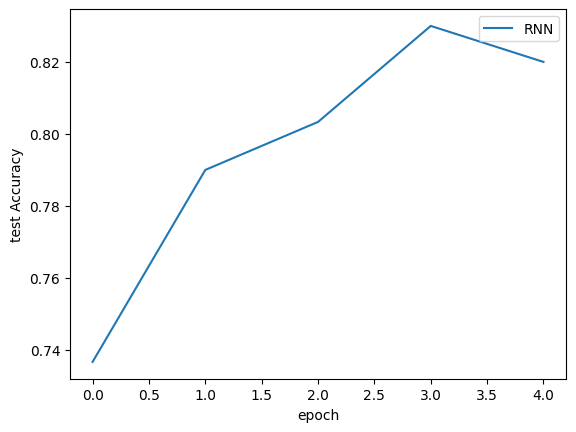

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='RNN')

In [ ]:
pred_rnn = first_rnn.to("cpu").eval()
with torch.inference_mode():
    preds = F.softmax(pred_rnn(dataset.string2InputVec("frank").reshape(1,-1)), dim=-1)
    for class_id in range(len(dataset.label_names)):
        print(dataset.label_names[class_id], ":", preds[0,class_id].item()*100 , "%")

Arabic : 0.004573294427245855 %
Chinese : 0.9569831192493439 %
Czech : 14.62152898311615 %
Dutch : 7.199884206056595 %
English : 39.6406352519989 %
French : 0.4209195263683796 %
German : 27.630063891410828 %
Greek : 0.010986290726577863 %
Irish : 1.7936155200004578 %
Italian : 0.2776417415589094 %
Japanese : 0.007154951163101941 %
Korean : 0.9700242429971695 %
Polish : 3.3255506306886673 %
Portuguese : 0.03802835999522358 %
Russian : 0.4141624551266432 %
Scottish : 1.7272122204303741 %
Spanish : 0.06050094380043447 %
Vietnamese : 0.9005378000438213 %


### More simple example

In [ ]:
import torch
import torch.nn as nn

# Sample data: 3 batches, each with 5 names
names_batch = [
    # Batch 1: 5 American names
    ["John", "Elizabeth", "Michael", "Jennifer", "Christopher"],

    # Batch 2: 5 Japanese names
    ["Hiroshi", "Yuki", "Takeshi", "Aiko", "Kenji"],

    # Batch 3: 5 Indian names
    ["Raj", "Priya", "Aditya", "Divya", "Vikram"]
]

# Step 1: Convert characters to indices
# First, create a vocabulary of all characters
all_chars = set()
for batch in names_batch:
    for name in batch:
        all_chars.update(name)

char_to_idx = {char: i+1 for i, char in enumerate(sorted(all_chars))}

# Add padding token
char_to_idx['<PAD>'] = 0
idx_to_char = {i: char for char, i in char_to_idx.items()}

print("Character vocabulary size:", len(char_to_idx))
print("Character mapping example:", {k: char_to_idx[k] for k in list(char_to_idx.keys())[:5]})

# Step 2: Find the longest name to determine max sequence length
max_name_length = max(len(name) for batch in names_batch for name in batch)
print("Maximum name length:", max_name_length)

# Step 3: Convert names to padded sequences of indices
# Shape will be [batch_size, seq_length, input_size]
# Where input_size=1 (one character at a time)
input_data = torch.zeros(3, 5, max_name_length, dtype=torch.long)

for batch_idx, batch in enumerate(names_batch):
    for name_idx, name in enumerate(batch):
        for char_idx, char in enumerate(name):
            input_data[batch_idx, name_idx, char_idx] = char_to_idx[char]

print("Input tensor shape:", input_data.shape)
print("\nEncoded first name in batch 1:", input_data[0, 0])
print("Decoded back:", ''.join([idx_to_char[idx.item()] for idx in input_data[0, 0] if idx.item() > 0]))

# Step 4: For RNN processing, we need to convert this to one-hot encoding or embeddings
# Let's use embeddings which is more efficient
vocab_size = len(char_to_idx)
embedding_dim = 10  # Size of character embeddings

class NameRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(NameRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        # We'll use the final hidden state for classification

    def forward(self, x):
        # x shape: [batch_size, seq_length] for each name
        embedded = self.embedding(x)  # Shape: [batch_size, seq_length, embedding_dim]
        output, hidden = self.rnn(embedded)
        return output, hidden

# For processing, we'd need to reshape our data
# Let's process one batch at a time for clarity
model = NameRNN(vocab_size, embedding_dim, hidden_size=20)

# Process the first name in each batch
first_names = input_data[:, 0, :]  # Shape: [3, max_name_length]
output, hidden = model(first_names)

print("\nOutput shape for first names:", output.shape)  # Should be [3, max_name_length, 20]
print("Hidden state shape:", hidden.shape)  # Should be [1, 3, 20]

Character vocabulary size: 36
Character mapping example: {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'H': 5}
Maximum name length: 11
Input tensor shape: torch.Size([3, 5, 11])

Encoded first name in batch 1: tensor([ 6, 27, 20, 26,  0,  0,  0,  0,  0,  0,  0])
Decoded back: John

Output shape for first names: torch.Size([3, 11, 20])
Hidden state shape: torch.Size([1, 3, 20])


## LSTM

1. choose a dataset
2. download and check the shape of the dataset
4. clean the data if needed (hint: regex)
5. decide the tokenization strategy (word , character , sub character)
6. build the vocab
7. build a wrapper around the dataset
8. dataloader -> train[0] (input,label)
9. Build network architecture
10. Training loop
11. evaluate


In [2]:
!pip install datasets

In [3]:
!pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [1]:
import re
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm

import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize


download_result = nltk.download('punkt_tab')
print("Download success:", download_result)


# For loading datasets
from datasets import load_dataset

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Download success: True
Libraries imported successfully!


In [2]:
# Download the dataset
dataset = load_dataset("imdb")

# Get train and test data
train_data = dataset["train"]
test_data = dataset["test"]

# Display sample data
print(f"Dataset loaded! Total training examples: {len(train_data)}")
print(f"Sample review (text): {train_data[0]['text'][:100]}...")
print(f"Sample label (0=negative, 1=positive): {train_data[0]['label']}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset loaded! Total training examples: 25000
Sample review (text): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
Sample label (0=negative, 1=positive): 0


In [3]:
def preprocess_text(text):
    """Clean and tokenize the text"""

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    return tokens


# Process training data
train_reviews = []
train_labels = []

for sample in tqdm(train_data):

    # Labels are already integers (0=negative, 1=positive)
    label_int = sample['label']
    train_labels.append(label_int)

    # Preprocess text
    tokens = preprocess_text(sample['text'])
    train_reviews.append(tokens)

# Process test data
test_reviews = []
test_labels = []

for sample in tqdm(test_data):
    label_int = sample['label']
    test_labels.append(label_int)
    tokens = preprocess_text(sample['text'])
    test_reviews.append(tokens)


print(f"Data preprocessing complete! Example tokenized review: {train_reviews[0][:15]}...")
print(f"Data preprocessing complete! Example tokenized label: {train_labels[0]}...")

100%|██████████| 25000/25000 [00:25<00:00, 990.40it/s] 

Data preprocessing complete! Example tokenized review: ['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that']...
Data preprocessing complete! Example tokenized label: 0...


In [4]:
def build_vocab(reviews, max_words=10000):
    """Build a vocabulary of the most common words"""
    word_count = Counter()

    # Count all words
    for review in reviews:
        word_count.update(review)

    # Select most common words
    most_common = word_count.most_common(max_words - 2)  # -2 for <UNK> and <PAD>
    vocab = {word: idx+2 for idx, (word, _) in enumerate(most_common)}

    # Add special tokens
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1

    return vocab

# Build vocabulary from training data
vocab = build_vocab(train_reviews)
vocab_size = len(vocab)

print(f"Vocabulary created with {vocab_size} words!")
print(f"Sample words: {list(vocab.items())[:10]}")

# Create a reverse mapping for decoding
idx_to_word = {idx: word for word, idx in vocab.items()}

Vocabulary created with 10000 words!
Sample words: [('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6), ('is', 7), ('in', 8), ('it', 9), ('this', 10), ('i', 11)]


What should be the maximum length of my sequence aka review ??

Maximum review length: 2441
Mean review length: 227.81
Median review length: 170.0
95th percentile length: 583.0


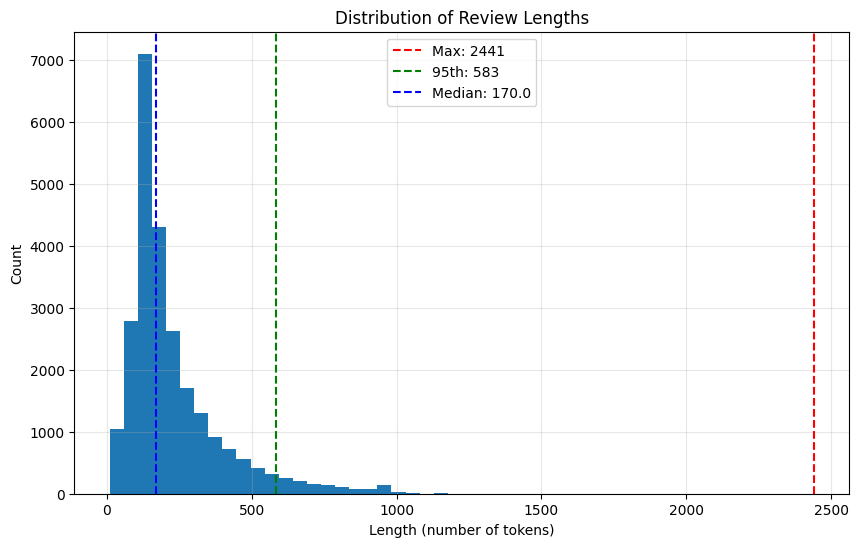

Chosen max_len: 583


100%|██████████| 25000/25000 [00:00<00:00, 25131.94it/s]


Data encoding complete! Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...
All sequences are now of length 583
Reviews truncated: 1245 (4.98%)


In [5]:
# Analyze review lengths to determine optimal max_len
review_lengths = [len(review) for review in train_reviews]
max_review_length = max(review_lengths)
mean_length = np.mean(review_lengths)
median_length = np.median(review_lengths)
p95_length = np.percentile(review_lengths, 95)

print(f"Maximum review length: {max_review_length}")
print(f"Mean review length: {mean_length:.2f}")
print(f"Median review length: {median_length}")
print(f"95th percentile length: {p95_length}")

# Plotting the distribution of review lengths
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50)
plt.axvline(x=max_review_length, color='r', linestyle='--', label=f'Max: {max_review_length}')
plt.axvline(x=p95_length, color='g', linestyle='--', label=f'95th: {p95_length:.0f}')
plt.axvline(x=median_length, color='b', linestyle='--', label=f'Median: {median_length}')
plt.title("Distribution of Review Lengths")
plt.xlabel("Length (number of tokens)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Choose max_len based on 95th percentile to avoid excessive padding
# while still covering most reviews without truncation
chosen_max_len = int(p95_length)
print(f"Chosen max_len: {chosen_max_len}")

def encode_review(review, vocab, max_len=None):
    """Convert a review to a fixed-length sequence of integers"""
    # Use the chosen max_len from analysis if none provided
    if max_len is None:
        max_len = chosen_max_len

    # Encode words, use <UNK> for unknown words
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]

    # Pad sequences to the same length
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded

# Encode all reviews using the dynamically determined max_len
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

# Convert to tensors
train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Data encoding complete! Example sequence: {train_sequences[0][:15]}...")
print(f"All sequences are now of length {chosen_max_len}")

# Calculate how many reviews were truncated
truncated_count = sum(1 for length in review_lengths if length > chosen_max_len)
truncated_percentage = (truncated_count / len(review_lengths)) * 100
print(f"Reviews truncated: {truncated_count} ({truncated_percentage:.2f}%)")


In [6]:
def encode_review(review, vocab, max_len=200):
    """Convert a review to a fixed-length sequence of integers"""
    # Encode words, use <UNK> for unknown words
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]

    # Pad sequences to the same length
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded

# Encode all reviews
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

# Convert to tensors
train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Data encoding complete! Example sequence: {train_sequences[0][:15]}...")

100%|██████████| 25000/25000 [00:01<00:00, 20406.52it/s]


Data encoding complete! Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...


In [7]:
class IMDbDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create train/validation split
train_seq, val_seq, train_labels, val_labels = train_test_split(
                                                                  train_sequences, train_labels_tensor, test_size=0.1, random_state=42
                                                              )

# Create datasets
train_dataset = IMDbDataset(train_seq, train_labels)
val_dataset = IMDbDataset(val_seq, val_labels)
test_dataset = IMDbDataset(test_sequences, test_labels_tensor)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"DataLoaders created! Training batches: {len(train_loader)}")

DataLoaders created! Training batches: 352


In [8]:
class SentimentLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5, bidirectional=False):

        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, text):

        # text shape: [batch_size, seq_len]
        # Embed the text
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]

        # Pass through LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # hidden shape: [n_layers, batch_size, hidden_dim]

        # Use the final hidden state
        hidden = self.dropout(hidden[-1, :, :])  # [batch_size, hidden_dim]

        # Pass through linear layer
        return self.fc(hidden)  # [batch_size, output_dim]


# Initialize model
embedding_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 2

model = SentimentLSTM(
                      vocab_size=vocab_size,
                      embedding_dim=embedding_dim,
                      hidden_dim=hidden_dim,
                      output_dim=output_dim,
                      n_layers=n_layers
                     )

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Model created and moved to {device}!")
print(model)

Model created and moved to cuda!
SentimentLSTM(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [9]:
# Binary Cross Entropy Loss
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function and optimizer defined!")

Loss function and optimizer defined!


In [10]:
def train(model, iterator, optimizer, criterion):
    """Training function for one epoch"""
    # Set model to training mode
    model.train()

    # Track loss
    epoch_loss = 0
    epoch_acc = 0

    # Iterate over batches
    for batch in tqdm(iterator, desc="Training"):

        # Get batch data
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(text).squeeze(1)

        # Calculate loss
        loss = criterion(predictions, labels)

        # Calculate accuracy
        predicted_classes = torch.round(torch.sigmoid(predictions))
        correct = (predicted_classes == labels).float()
        accuracy = correct.sum() / len(correct)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()
        epoch_acc += accuracy.item()

    # Return average loss and accuracy
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [11]:
def evaluate(model, iterator, criterion):
    """Evaluation function"""
    # Set model to evaluation mode
    model.eval()

    # Track loss
    epoch_loss = 0
    epoch_acc = 0

    # No gradients needed for evaluation
    with torch.no_grad():
        # Iterate over batches
        for batch in tqdm(iterator, desc="Evaluating"):
            # Get batch data
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            # Forward pass
            predictions = model(text).squeeze(1)

            # Calculate loss
            loss = criterion(predictions, labels)

            # Calculate accuracy
            predicted_classes = torch.round(torch.sigmoid(predictions))
            correct = (predicted_classes == labels).float()
            accuracy = correct.sum() / len(correct)

            # Update metrics
            epoch_loss += loss.item()
            epoch_acc += accuracy.item()

    # Return average loss and accuracy
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [12]:
n_epochs = 2

# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Training loop
for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-" * 20)

    # Train
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

print("\nTraining complete!")


Epoch 1/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 83.05it/s]


Train Loss: 0.6933 | Train Acc: 50.82%
Val Loss: 0.6944 | Val Acc: 48.79%

Epoch 2/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 81.79it/s]

Train Loss: 0.6930 | Train Acc: 51.51%
Val Loss: 0.6807 | Val Acc: 58.32%

Training complete!


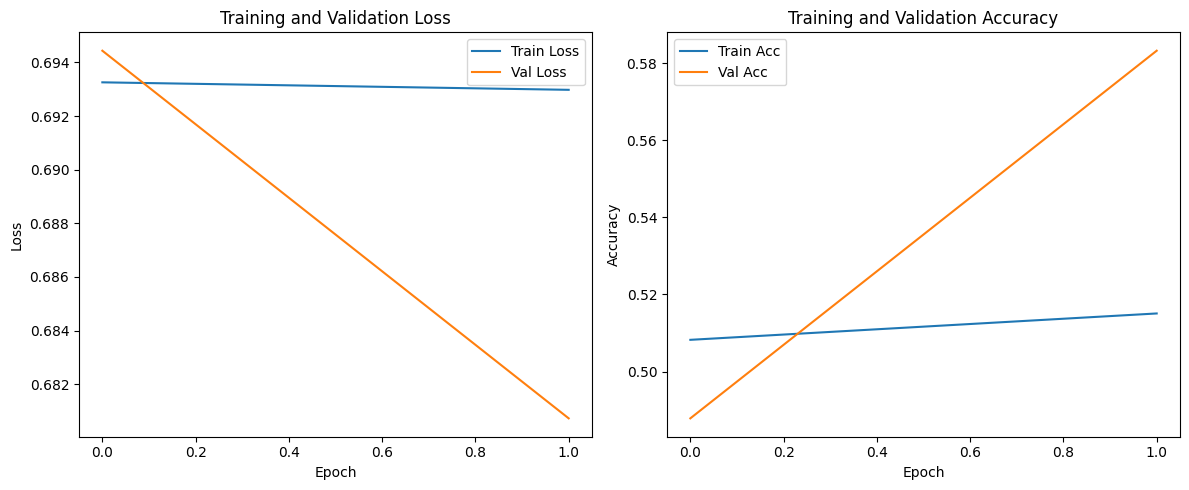

In [13]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Evaluating: 100%|██████████| 391/391 [00:04<00:00, 80.71it/s]

Test Loss: 0.6844 | Test Acc: 56.84%


In [15]:
def predict_sentiment(model, text, vocab, max_len=200):
    """Predict sentiment for a single text input"""

    # Preprocess
    tokens = preprocess_text(text)

    # Encode
    encoded = encode_review(tokens, vocab, max_len)

    # Convert to tensor
    tensor = torch.tensor(encoded).unsqueeze(0).to(device)  # Add batch dimension

    # Set model to evaluation mode
    model.eval()

    # Get prediction
    with torch.no_grad():
        prediction = torch.sigmoid(model(tensor).squeeze(1))

    # Return probability and sentiment
    probability = prediction.item()
    sentiment = "Positive" if probability >= 0.5 else "Negative"

    return probability, sentiment


# Test on some examples
sample_reviews = [
                  "This movie was absolutely amazing! The acting was superb and the plot was engaging.",
                  "I was thoroughly disappointed with this film. The story made no sense and the acting was terrible.",
                  "It was okay. Nothing special but not terrible either.",
                  "Despite some flaws in the plot, the movie had great visual effects and good performances."
                ]


print("Model predictions on sample reviews:")

for review in sample_reviews:
    prob, sent = predict_sentiment(model, review, vocab)
    print(f"Review: {review[:50]}...")
    print(f"Sentiment: {sent} (probability: {prob:.4f})")
    print("-" * 50)

Model predictions on sample reviews:
Review: This movie was absolutely amazing! The acting was ...
Sentiment: Positive (probability: 0.5487)
--------------------------------------------------
Review: I was thoroughly disappointed with this film. The ...
Sentiment: Positive (probability: 0.5487)
--------------------------------------------------
Review: It was okay. Nothing special but not terrible eith...
Sentiment: Positive (probability: 0.5487)
--------------------------------------------------
Review: Despite some flaws in the plot, the movie had grea...
Sentiment: Negative (probability: 0.4395)
--------------------------------------------------


In [16]:
# Save model
torch.save({
            'model_state_dict': model.state_dict(),
            'vocab': vocab,
            'model_params': {
                            'vocab_size': vocab_size,
                            'embedding_dim': embedding_dim,
                            'hidden_dim': hidden_dim,
                            'output_dim': output_dim,
                            'n_layers': n_layers
                            }
            }, 'lstm_sentiment_model.pt')

print("Model saved successfully!")

Model saved successfully!


Task :
1. train a 1/3 layered network and compare the results
2. change the task from many to one to many to many tasK

#### 1- Stacked (4 layers) without bidirection

In [17]:
# Initialize model (without bidirectional RNN)
embedding_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 4

model2 = SentimentLSTM(
                        vocab_size=vocab_size,
                        embedding_dim=embedding_dim,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers
                      )

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)
print(f"Model created and moved to {device}!")
print(model2)

Model created and moved to cuda!
SentimentLSTM(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [18]:
# Binary Cross Entropy Loss
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer
optimizer = optim.Adam(model2.parameters(), lr=0.001)

print("Loss function and optimizer defined!")

Loss function and optimizer defined!


In [19]:
n_epochs = 2

# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []


# Training loop
for epoch in range(n_epochs):

    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-" * 20)

    # Train
    train_loss, train_acc = train(model2, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    val_loss, val_acc = evaluate(model2, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

print("\nTraining complete!")


Epoch 1/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 43.40it/s]


Train Loss: 0.6947 | Train Acc: 50.25%
Val Loss: 0.6939 | Val Acc: 48.79%

Epoch 2/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 42.51it/s]

Train Loss: 0.6937 | Train Acc: 49.85%
Val Loss: 0.6928 | Val Acc: 51.29%

Training complete!


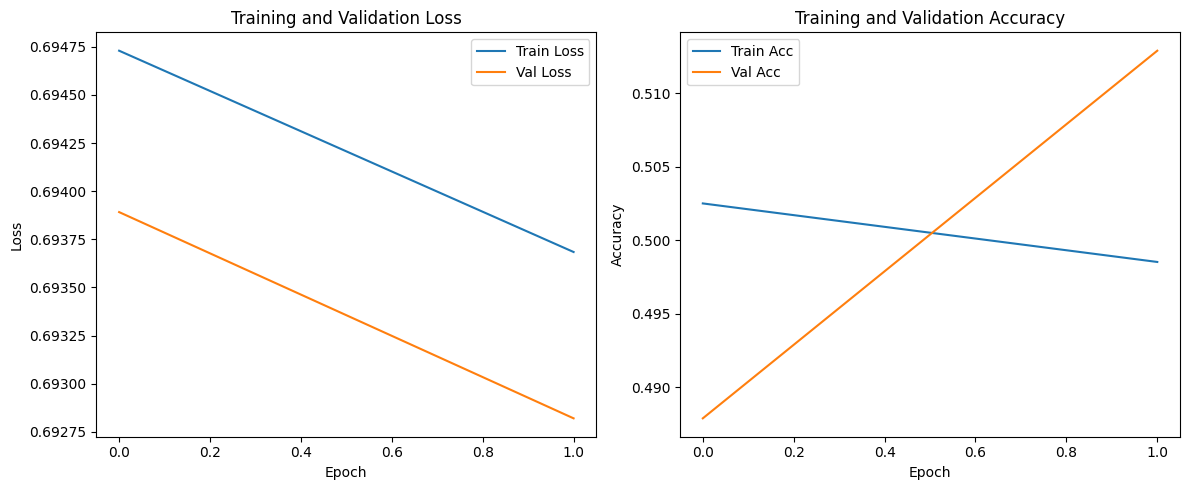

In [20]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
test_loss, test_acc = evaluate(model2, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Evaluating: 100%|██████████| 391/391 [00:09<00:00, 41.61it/s]

Test Loss: 0.6932 | Test Acc: 49.95%


#### 2- Stacked (4 layers) with bidirection

In [22]:
# Initialize model (without bidirectional RNN)
embedding_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 4

model3 = SentimentLSTM(
                        vocab_size=vocab_size,
                        embedding_dim=embedding_dim,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        bidirectional=True
                      )

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3 = model3.to(device)
print(f"Model created and moved to {device}!")
print(model3)

Model created and moved to cuda!
SentimentLSTM(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [23]:
# Binary Cross Entropy Loss
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer
optimizer = optim.Adam(model3.parameters(), lr=0.001)

print("Loss function and optimizer defined!")

Loss function and optimizer defined!


In [24]:
n_epochs = 2

# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []


# Training loop
for epoch in range(n_epochs):

    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-" * 20)

    # Train
    train_loss, train_acc = train(model3, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    val_loss, val_acc = evaluate(model3, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

print("\nTraining complete!")


Epoch 1/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


Train Loss: 0.6703 | Train Acc: 58.00%
Val Loss: 0.6785 | Val Acc: 57.42%

Epoch 2/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 16.73it/s]

Train Loss: 0.6327 | Train Acc: 63.44%
Val Loss: 0.6887 | Val Acc: 53.87%

Training complete!


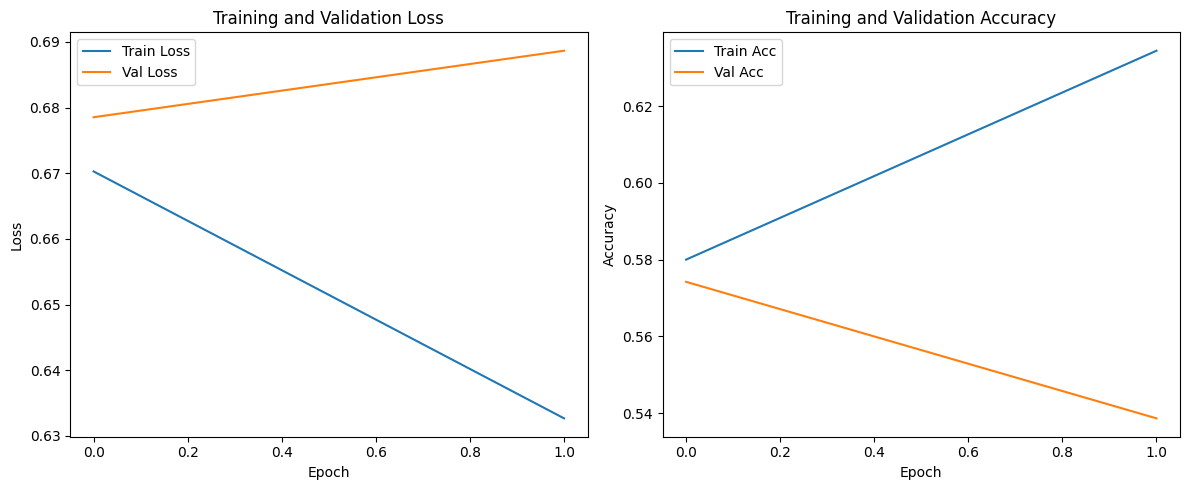

In [25]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
test_loss, test_acc = evaluate(model3, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Evaluating: 100%|██████████| 391/391 [00:23<00:00, 16.50it/s]

Test Loss: 0.6909 | Test Acc: 52.70%


#### 3- Many to Many Task (Translation)

In [27]:
dataset = load_dataset("iwslt2017", "iwslt2017-en-de", trust_remote_code=True)

train_data = dataset["train"]
test_data = dataset["test"]

README.md:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

iwslt2017.py:   0%|          | 0.00/8.17k [00:00<?, ?B/s]

en-de.zip:   0%|          | 0.00/16.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/206112 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8079 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/888 [00:00<?, ? examples/s]

In [28]:
# Display sample data
print(f"Dataset loaded! Total training examples: {len(train_data)}")
print(f'Sample (english & deutch): {train_data[0]["translation"]}')

Dataset loaded! Total training examples: 206112
Sample (english & deutch): {'de': 'Vielen Dank, Chris.', 'en': 'Thank you so much, Chris.'}


In [29]:
def preprocess_text(text):
    """Clean and tokenize the text"""

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    return tokens



# Process training data
train_text = []
train_labels = []


for sample in tqdm(train_data):

    # Preprocess Targets
    target_tokens = preprocess_text(sample['translation']['de'])
    train_labels.append(target_tokens)

    # Preprocess text
    tokens = preprocess_text(sample['translation']['en'])
    train_text.append(tokens)



# Process test data
test_text = []
test_labels = []

for sample in tqdm(test_data):

    target_tokens = preprocess_text(sample['translation']['de'])
    test_labels.append(target_tokens)

    tokens = preprocess_text(sample['translation']['en'])
    test_text.append(tokens)


print(f"Data preprocessing complete! Example tokenized review: {train_text[0][:15]}...")
print(f"Data preprocessing complete! Example tokenized label: {train_labels[0]}...")

100%|██████████| 8079/8079 [00:01<00:00, 4762.05it/s]

Data preprocessing complete! Example tokenized review: ['thank', 'you', 'so', 'much', 'chris']...
Data preprocessing complete! Example tokenized label: ['vielen', 'dank', 'chris']...


In [30]:
def build_english_vocab(text, max_words=10000):
    """Build a vocabulary of the most common words"""
    word_count = Counter()

    # Count all words
    for sentence in text:
        word_count.update(sentence)

    # Select most common words
    most_common = word_count.most_common(max_words - 2)  # -2 for <UNK> and <PAD>
    vocab = {word: idx+2 for idx, (word, _) in enumerate(most_common)}

    # Add special tokens
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1

    return vocab


# Build vocabulary from training data
english_vocab = build_english_vocab(train_text)
vocab_size = len(english_vocab)

print(f"Vocabulary created with {vocab_size} words!")
print(f"Sample words: {list(english_vocab.items())[:10]}")

# Create a reverse mapping for decoding
english_idx_to_word = {idx: word for word, idx in english_vocab.items()}

Vocabulary created with 10000 words!
Sample words: [('the', 2), ('and', 3), ('to', 4), ('of', 5), ('a', 6), ('that', 7), ('in', 8), ('i', 9), ('is', 10), ('you', 11)]


In [31]:
def build_german_vocab(text, max_words=10000):
    """Build a vocabulary of the most common words"""

    word_count = Counter()

    # Count all words
    for sentence in text:
        word_count.update(sentence)

    # Select most common words
    most_common = word_count.most_common(max_words - 4)  # -4 for <UNK>, <PAD>, '<SOS>', and '<EOS>'
    vocab = {word: idx+4 for idx, (word, _) in enumerate(most_common)}

    # Add special tokens
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    vocab['<SOS>'] = 2
    vocab['<EOS>'] = 3

    return vocab


# Build vocabulary from training data
german_vocab = build_english_vocab(train_labels)
vocab_size = len(german_vocab)

print(f"Vocabulary created with {vocab_size} words!")
print(f"Sample words: {list(german_vocab.items())[:10]}")

# Create a reverse mapping for decoding
german_idx_to_word = {idx: word for word, idx in german_vocab.items()}

Vocabulary created with 10000 words!
Sample words: [('und', 2), ('die', 3), ('sie', 4), ('das', 5), ('ich', 6), ('der', 7), ('ist', 8), ('wir', 9), ('es', 10), ('in', 11)]


Maximum review length: 92
Mean review length: 17.09
Median review length: 14.0
95th percentile length: 41.0


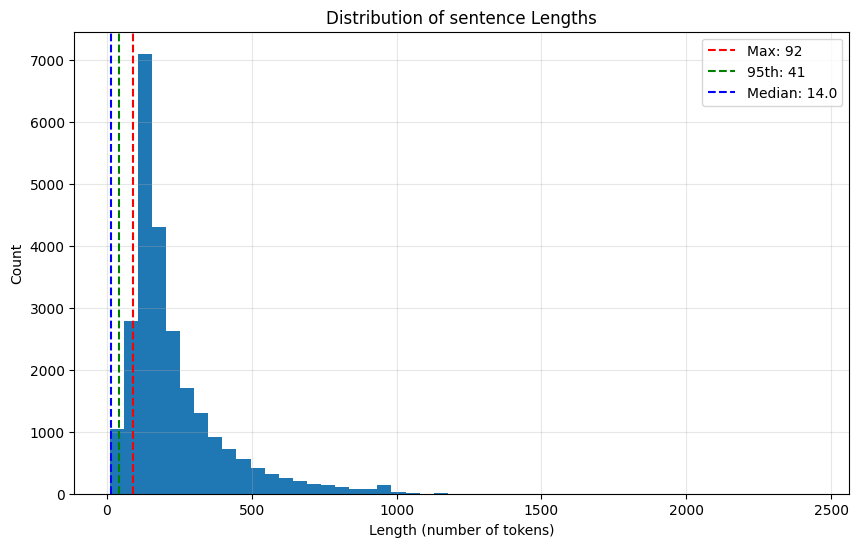

Chosen max_len: 41


100%|██████████| 8079/8079 [00:00<00:00, 217117.73it/s]


Data encoding complete! Example sequence: tensor([ 155,   11,   15,  103, 1053,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])...
All sequences are now of length 41
Sentences truncated: 9551 (4.63%)


In [32]:
# Analyze text lengths to determine optimal max_len
sentence_lengths = [len(text) for text in train_text]
max_sentence_length = max(sentence_lengths)

mean_length = np.mean(sentence_lengths)
median_length = np.median(sentence_lengths)
p95_length = np.percentile(sentence_lengths, 95)

print(f"Maximum review length: {max_sentence_length}")
print(f"Mean review length: {mean_length:.2f}")
print(f"Median review length: {median_length}")
print(f"95th percentile length: {p95_length}")

# Plotting the distribution of sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50)
plt.axvline(x=max_sentence_length, color='r', linestyle='--', label=f'Max: {max_sentence_length}')
plt.axvline(x=p95_length, color='g', linestyle='--', label=f'95th: {p95_length:.0f}')
plt.axvline(x=median_length, color='b', linestyle='--', label=f'Median: {median_length}')

plt.title("Distribution of sentence Lengths")
plt.xlabel("Length (number of tokens)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Choose max_len based on 95th percentile to avoid excessive padding
# while still covering most sentences without truncation
chosen_max_len = int(p95_length)
print(f"Chosen max_len: {chosen_max_len}")

def encode_sentence(sentence, vocab, max_len=None, add_sos_eos=False):
    """Convert a sentence to a fixed-length sequence of integers"""

    if add_sos_eos:
      sentence = ['<SOS>'] + sentence + ['<EOS>']

    # Use the chosen max_len from analysis if none provided
    if max_len is None:
        max_len = chosen_max_len

    # Encode words, use <UNK> for unknown words
    encoded = [vocab.get(word, vocab['<UNK>']) for word in sentence[:max_len]]

    # Pad sequences to the same length
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded

# Encode all sentences using the dynamically determined max_len
train_encoded = [encode_sentence(sentence, english_vocab) for sentence in tqdm(train_text)]
test_encoded = [encode_sentence(sentence, english_vocab) for sentence in tqdm(test_text)]

train_labels_encoded = [encode_sentence(sentence, german_vocab) for sentence in tqdm(train_labels)]
test_labels_encoded = [encode_sentence(sentence, german_vocab) for sentence in tqdm(test_labels)]

# Convert to tensors
train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)

test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)


print(f"Data encoding complete! Example sequence: {train_sequences[0][:15]}...")
print(f"All sequences are now of length {chosen_max_len}")

# Calculate how many sentences were truncated
truncated_count = sum(1 for length in sentence_lengths if length > chosen_max_len)
truncated_percentage = (truncated_count / len(sentence_lengths)) * 100
print(f"Sentences truncated: {truncated_count} ({truncated_percentage:.2f}%)")

In [33]:
def encode_sentence(sentence, vocab, max_len=200, add_sos_eos=False):
    """Convert a sentence to a fixed-length sequence of integers"""

    if add_sos_eos:
        sentence = ['<SOS>'] + sentence + ['<EOS>']

    # Encode words, use <UNK> for unknown words
    encoded = [vocab.get(word, vocab['<UNK>']) for word in sentence[:max_len]]

    # Pad sequences to the same length
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded



# Encode all sentences
train_encoded = [encode_sentence(sentence, english_vocab) for sentence in tqdm(train_text)]
train_labels_encoded = [encode_sentence(sentence, german_vocab, add_sos_eos=True) for sentence in tqdm(train_labels)]

test_encoded = [encode_sentence(sentence, english_vocab) for sentence in tqdm(test_text)]
test_labels_encoded = [encode_sentence(sentence, german_vocab, add_sos_eos=True) for sentence in tqdm(test_labels)]


# Convert to tensors
train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)

test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

print(f"Data encoding complete! Example sequence: {train_sequences[0][:15]}...")

100%|██████████| 8079/8079 [00:00<00:00, 145948.06it/s]


Data encoding complete! Example sequence: tensor([ 155,   11,   15,  103, 1053,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])...


In [34]:
class TranslationDataset(Dataset):

    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create train/validation split
train_seq, val_seq, train_labels, val_labels = train_test_split(
                                                                  train_sequences, train_labels_tensor, test_size=0.1, random_state=42
                                                               )

# Create datasets
train_dataset = TranslationDataset(train_seq, train_labels)
val_dataset = TranslationDataset(val_seq, val_labels)
test_dataset = TranslationDataset(test_sequences, test_labels_tensor)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"DataLoaders created! Training batches: {len(train_loader)}")

DataLoaders created! Training batches: 2899


In [35]:
class Encoder(nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)


    def forward(self, src):

        '''
        A Function that takes an english sentence creates an embedding to each word in that sentence, pass these embeddings of each token/word one step at a time to the lstm,
        the lstm then output the context vector representing that sentence (of hidden_size dimension).

        Args:
          src (tensor): The input sequence (the english sentence we want to encode).

        Returns:
          hidden (tensor): Final Vector that represents the final hidden state after encoding the input sentence (context vector of the final step).
          cell (tensor): Final Vector that represents the final cell state after encoding the input sentence (context vector of the final step).
        '''

        embedded = self.dropout(self.embedding(src))                            # [batch_size, src_len, emb_dim]
        outputs, (hidden, cell) = self.lstm(embedded)

        return hidden, cell

In [36]:
class Decoder(nn.Module):

    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)



    def forward(self, input, hidden, cell):

        '''
        A Function that takes a german sentence creates an embedding to each word in that sentence, pass these embeddings of each token/word one step at a time to the lstm along with the context vectors from previous states,
        the lstm then outputs the vector which would be passed to the linear layers to generate probabilities for each token.

        Args:
          input (tensor): The input sequence (the german sentence we want to encode).
          hidden (tensor): Final Vector that represents the final previous hidden state.
          cell (tensor): Final Vector that represents the final previous cell state.

        Returns:
          prediction (tensor):
          hidden (tensor): Final Vector that represents the final hidden state.
          cell (tensor): Final Vector that represents the final cell state.
        '''

        # input: [batch_size] -> need [batch_size, 1] for single token
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))  # [batch_size, 1, emb_dim]
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # output: [batch_size, 1, hidden_dim]
        prediction = self.fc_out(output.squeeze(1))  # [batch_size, output_dim]

        return prediction, hidden, cell

In [37]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):

        '''
        A function that performes translation from english to german using sequence to sequence modelling.

        Args:

          src (): The english sentence we want to translate.
          trg (): The targeted german sentence (ground truth).
          teacher_forcing_ratio ():

        Returns:
          outputs (tensor): The translated german sentence.
        '''

        batch_size = src.shape[0]
        trg_len = trg.shape[1]

        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)
        input = trg[:, 0]  # first <sos> token


        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs

In [38]:
def train(model, iterator, optimizer, criterion, clip, teacher_forcing_ratio=0.5):
    """
    Train the Seq2Seq model for one epoch.
    Args:
        model: The Seq2Seq model
        iterator: DataLoader iterator
        optimizer: Optimizer (e.g., Adam)
        criterion: Loss function (CrossEntropyLoss)
        clip: Gradient clipping value
        teacher_forcing_ratio: Probability of using teacher forcing during training
    Returns:
        epoch_loss: Average loss for the epoch
    """

    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in tqdm(iterator, desc="Training"):

        # Get batch data (source and target sequences)
        src, trg = batch
        src, trg = src.to(device), trg.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass through the model
        output = model(src, trg, teacher_forcing_ratio)

        # output shape: [batch_size, trg_len, trg_vocab_size]
        # trg shape: [batch_size, trg_len]

        # Flatten the output and target for CrossEntropyLoss
        output = output[:, 1:].reshape(-1, output.shape[-1])  # [batch_size * trg_len, output_dim]
        trg = trg[:, 1:].reshape(-1)  # [batch_size * trg_len]

        # Calculate loss
        loss = criterion(output, trg)

        # Calculate accuracy
        # Predicted token: the one with the highest probability (argmax)
        _, predicted = output.max(1)

        # Calculate the number of correct predictions
        correct = (predicted == trg).float()
        accuracy = correct.sum() / len(correct)

        # Backward pass
        loss.backward()

        # Gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Update model parameters
        optimizer.step()

        # Update the epoch loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += accuracy.item()

    # Return average loss and accuracy for the epoch
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
def evaluate(model, dataloader, criterion, device, trg_pad_idx):

    model.eval()  # Set model to evaluation mode

    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():

        for src, trg in dataloader:

            src, trg = src.to(device), trg.to(device)

            # Get model outputs
            output = model(src, trg, teacher_forcing_ratio=0)  # No teacher forcing during evaluation

            # output: [batch_size, trg_len, output_dim]
            # trg: [batch_size, trg_len]

            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)

            # Compute accuracy
            preds = output.argmax(dim=1)
            non_pad = trg != trg_pad_idx
            correct = (preds == trg) & non_pad
            acc = correct.sum().float() / non_pad.sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)


In [40]:
INPUT_DIM = len(english_vocab)       # English vocab size
OUTPUT_DIM = len(german_vocab)      # German vocab size
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
N_LAYERS = 2
DROPOUT = 0.5

enc = Encoder(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4 = Seq2Seq(enc, dec, device).to(device)

print(f"Model created and moved to {device}!")
print(model4)

Model created and moved to cuda!
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 100, padding_idx=0)
    (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 100, padding_idx=0)
    (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=10000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


In [41]:
# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(model4.parameters(), lr=0.001)

print("Loss function and optimizer defined!")

Loss function and optimizer defined!


In [42]:
n_epochs = 1
clip = 1.0            # Gradient clipping value

# Lists to store metrics
train_losses = []
train_accs = []

val_losses = []
val_accs = []


# Training loop
for epoch in range(n_epochs):

    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-" * 20)

    # Train
    train_loss, train_acc = train(model4, train_loader, optimizer, criterion, clip)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    trg_pad_idx = german_vocab['<PAD>']
    val_loss, val_acc = evaluate(model4, val_loader, criterion, device, trg_pad_idx)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

print("\nTraining complete!")


Epoch 1/1
--------------------


Training: 100%|██████████| 2899/2899 [1:14:11<00:00,  1.54s/it]


Train Loss: 0.5624 | Train Acc: 92.25%
Val Loss: 0.8111 | Val Acc: 3.81%

Training complete!


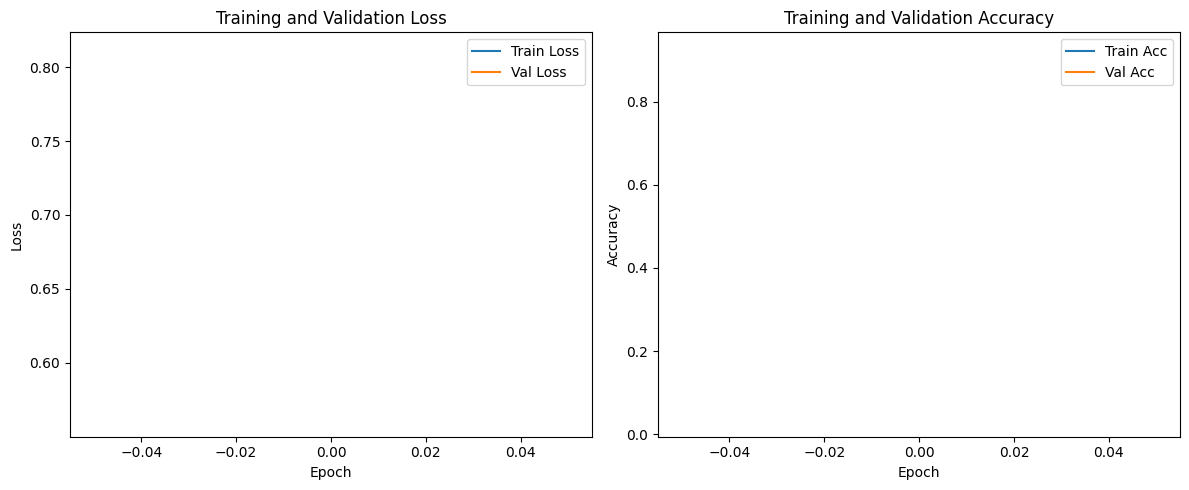

In [43]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
test_loss, test_acc = evaluate(model4, test_loader, criterion, device, trg_pad_idx)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.7799 | Test Acc: 4.19%
